Let's import the necessary modules.
* pycountry courtesy of Christian Theune [https://pypi.org/project/pycountry/], Licence: LGPL
* wordcloud courtesy of Andreas Mueller [https://github.com/amueller/word_cloud], Licence: MIT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycountry as pyc
import matplotlib
import plotly.offline as offline
#from wordcloud import WordCloud

In [2]:
df = pd.read_csv(".\data\winemag-data_first150k.csv", index_col=0)

## Overview

What does the data actually look like?

In [3]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


We have 10 columns for every review:

5 columns describing the origin of the bottle:
* Country
* Province
* Region 1
* Region 2
* Winery

And:

* Designation
* Variety
* Description
* Points (out of 100)
* Price (in US$)

We can look into how the ratings vary with price. Let's look a bit deeper into the data, first.

In [4]:
df['price'].describe()

count    137235.000000
mean         33.131482
std          36.322536
min           4.000000
25%          16.000000
50%          24.000000
75%          40.000000
max        2300.000000
Name: price, dtype: float64

A vast majority of the wines review cost less than 50 USD with a mean of 33 USD. However, we will also have some really expensive items, up to 2,300 USD (!) per bottle.

In [5]:
df['points'].describe()

count    150930.000000
mean         87.888418
std           3.222392
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

The user ratings look quite evenly distributed between the scores of 80 and 100.

## Visualisations

### Scatter

**TODO**: Show a simple scatter plot and why a log scale needs to be used.

If the prices were separated in roughly similar intervals, we could be looking at a linear relationship. However, from the looks of it, we are going to have to plot the price on a logarithmic scale.

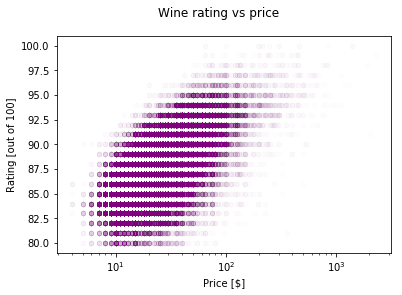

In [6]:
fig = plt.figure()

plt.scatter(df['price'], df['points'], s=25, alpha=0.008, c='purple', marker='h') #alpha to emphasise relative density of data points

ax = plt.gca()
ax.set_xscale('log')

fig.suptitle('Wine rating vs price', fontsize=12)
ax.set_xlabel('Price [$]')
ax.set_ylabel('Rating [out of 100]')

plt.show()

**TODO** Slice data between 10 USD and 100 USD, and see if you can find have find a better relationship.

We can see a vague linear correlation between the log'd price and the user rating, with the major cluster at prices 10-100 USD and 80-95 points. The cluster is so wide in both directions, however, that it is quite impossible to reliably predict a value of one metric based on the other.

For example, for a price of 20 USD, you are as likely to find a bottle with rating 82.5 as you are with 92.5. Or to find an item with a rating of 90 to cost 10 USD or 100 USD.

### Map

Let's try to model the metrics against different dimensions. From what is left, we can take a look at how ratings and prices vary around the world. One way to do that is with a choropleth map. Plotly has a very good tool for creating those.
Before populating the map with data, we need to prepare it to match plotly's specification.

#### Prepare data

The original dataset identifies countries by their full name. We will need something more standardised than that. This short function returns an ISO-3 country code from a country name.

In [ ]:
#Get country ISO-3 code from a name
def ccode(cname):
    
    #Check if the name exists in the pycountry list
    try:
        return pyc.countries.get(name=cname).alpha_3
    
    except KeyError:
        
        #Check if the short name works (e.g. US)
        try:    
            return pyc.countries.get(alpha_2=cname).alpha_3
        
        except KeyError:
            return None
    
    #Special case for UK 
    if(cname=='UK'):
        return 'GBR'

Now, let's apply it to our DataFrame.

In [ ]:
#Apply the country coding function
df['country_code'] = df['country'].apply(ccode)

It's time to generate some new metrics. Let's count the numbers of reviews for each country and add this data to a new DataFrame.

In [ ]:
world_occurences = df['country_code'].value_counts()
world_occurences = world_occurences.dropna()

df_map = pd.DataFrame({'occurences': world_occurences})

To create a (static) choropleth map, we need a single value for each country

In [ ]:
#Average score for each country
df_map['avg_points'] = df.groupby('country_code')['points'].mean()
#Average price for each country ($ ?)
df_map['avg_price'] = df.groupby('country_code')['price'].mean()

#Create dictionary for mapping country names to country codes from the initial DataFrame
cmap = df[['country_code', 'country']].copy().dropna().drop_duplicates().set_index('country_code').to_dict()['country']
df_map['country_code'] = df_world.index
#Map country names to codes
df_map['country'] = df_map['country_code'].map(cmap)

In [ ]:
#Formats a cmap into an RGB map ---(source: plotly API)---
def cmap_RGB(col_map, inverse):
    
    cmap = matplotlib.cm.get_cmap(col_map)
    col_map_rgb = []
    norm = matplotlib.colors.Normalize(vmin=0, vmax=255)
    
    for i in range(0, 255):
        k = matplotlib.colors.colorConverter.to_rgb(cmap(norm(i)))
        col_map_rgb.append(k)
    
    def matplotlib_plotly(c_map, pl_entries):
        h = 1.0/(pl_entries-1)
        pl_colorscale = []
        
        for k in range(pl_entries):
            
            if(inverse):
                idx = ((pl_entries-1)-k)*h #inverse the colour order
            else:
                idx = k*h #regular order
            
            
            c = list(map(np.uint8, np.array(c_map(idx)[:3])*255))
            pl_colorscale.append([k*h, 'rgb'+str((c[0], c[1], c[2]))])
            
        return pl_colorscale
    
    return matplotlib_plotly(cmap, 255)

In [ ]:
#Create a choropleth chart ---(source: plotly API)---
#def choropleth(df_world, world_meas, measure):
    
#Data and styling for plotting
data = [dict(
        type = 'choropleth',
        locations =  df_world['country_code'], #dimension, displayed
        z = df_world[world_meas], #measure, displayed
        text = df_world['country'], #displayed country names
        colorscale = cmap_RGB('BuPu', True),
        autocolorscale = False,
        reversescale = True, #legend goes from high to low
        marker = dict(
                line = dict(
                        color = 'rgb(180,180,180)',
                        width = 0.5
                        )),
        colorbar = dict(
                title = measure),)]

In [ ]:
#Chart layout properties
layout = dict(
        title = measure + ' per country',
        geo = dict(
                showframe = False,
                showcoastlines = False, #country coastlines
                showcountries = True, #country borders
                projection = dict(
                        type = 'Mercator')))

In [ ]:
#Combine chart properties
fig = dict(
        data = data,
        layout = layout)

#Save an offline copy of the chart
offline.plot(fig, filename='wine-scores-map.html')